In [14]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [15]:
# Load the data
data = pd.read_csv('Resources/AMZN.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter the data to include only the last 10 years
# cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=4)
# data = data[data['Date'] >= cutoff_date]

# Ensure the data is sorted by date
data = data.sort_values(by='Date')

In [16]:
# Creating moving average features
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# Drop the rows with NaN values (caused by rolling windows)
data = data.dropna()

# Define the target variable and features
features = ['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_10']
target = 'Close'

# Split the data into training and testing sets
train_data = data[data['Date'] < '2022-01-01']  
test_data = data[data['Date'] >= '2022-01-01']  

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [17]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.555575018602638


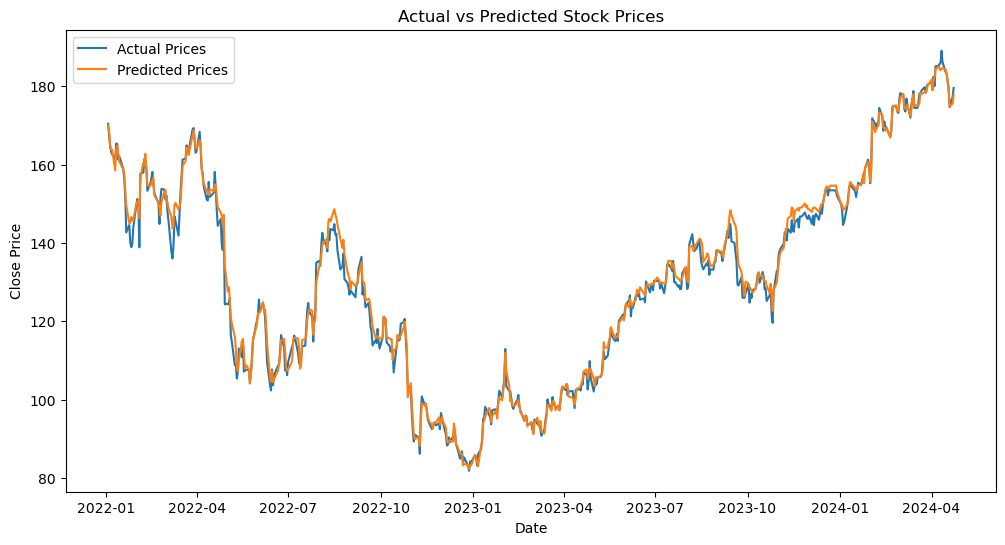

In [18]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], y_test, label='Actual Prices')
plt.plot(test_data['Date'], predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [19]:
# Predict future prices for the next month
def predict_next_month(model, last_data, features, days=30):
    future_predictions = []
    last_date = last_data['Date'].max()
    
    for i in range(days):
        last_row = last_data.iloc[-1]
        new_row = last_row.copy()
        
        # Move the date forward by one day
        new_row['Date'] = last_date + pd.Timedelta(days=1)
        
        # Predict the next closing price
        prediction = model.predict([last_row[features]])[0]
        new_row['Close'] = prediction
        
        # Update the moving averages
        last_data = pd.concat([last_data, new_row.to_frame().T], ignore_index=True)
        last_data['MA_5'] = last_data['Close'].rolling(window=5).mean()
        last_data['MA_10'] = last_data['Close'].rolling(window=10).mean()
        
        # Append the prediction to the future predictions list
        future_predictions.append(new_row)
        
        # Update the last_date
        last_date = new_row['Date']
        
        # Remove NaN values that may appear during the moving average calculation
        last_data = last_data.dropna()
    
    return pd.DataFrame(future_predictions)

# Prepare the last data point for prediction
last_data = data.copy()

# Predict future prices
future_predictions = predict_next_month(model, last_data, features)

c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\de

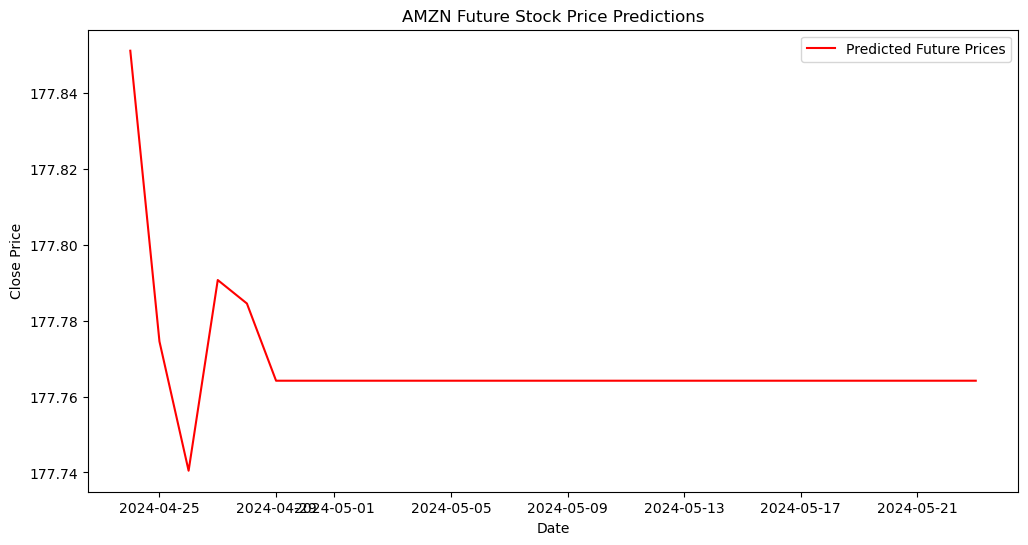

In [20]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_predictions['Date'], future_predictions['Close'], label='Predicted Future Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AMZN Future Stock Price Predictions')
plt.legend()

# Save the figure
plt.savefig('One-Month-Prediction-Graphs/AMZNmonthbydayforecast.png')

plt.show()

In [22]:
print(future_predictions[['Date', 'Close']])

           Date       Close
6778 2024-04-24  177.851170
6770 2024-04-25  177.774535
6762 2024-04-26  177.740460
6754 2024-04-27  177.790725
6746 2024-04-28  177.784535
6738 2024-04-29  177.764185
6730 2024-04-30  177.764185
6722 2024-05-01  177.764185
6714 2024-05-02  177.764185
6706 2024-05-03  177.764185
6698 2024-05-04  177.764185
6690 2024-05-05  177.764185
6682 2024-05-06  177.764185
6674 2024-05-07  177.764185
6666 2024-05-08  177.764185
6658 2024-05-09  177.764185
6650 2024-05-10  177.764185
6642 2024-05-11  177.764185
6634 2024-05-12  177.764185
6626 2024-05-13  177.764185
6618 2024-05-14  177.764185
6610 2024-05-15  177.764185
6602 2024-05-16  177.764185
6594 2024-05-17  177.764185
6586 2024-05-18  177.764185
6578 2024-05-19  177.764185
6570 2024-05-20  177.764185
6562 2024-05-21  177.764185
6554 2024-05-22  177.764185
6546 2024-05-23  177.764185


In [23]:
future_predictions.to_csv('One-Month-Predictions/AMZN-prediction.csv', index=False)

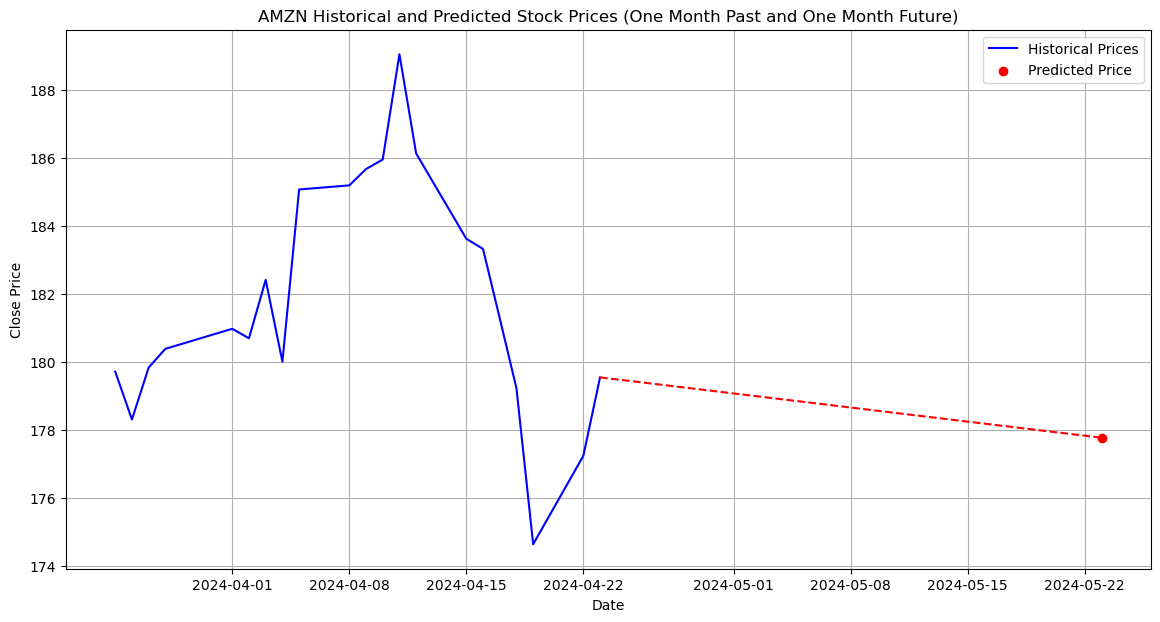

In [24]:
# Combine historical and predicted data
combined_data = pd.concat([data, future_predictions])

# Filter the combined data to include only the last month of historical data and next month of predictions
one_month_ago = data['Date'].max() - pd.DateOffset(days=30)
future_predictions_start = future_predictions['Date'].min()

filtered_combined_data = combined_data[
    (combined_data['Date'] >= one_month_ago) & 
    (combined_data['Date'] <= future_predictions_start + pd.DateOffset(days=30))
]

# Separate historical and predicted data
historical_data = filtered_combined_data[filtered_combined_data['Date'] <= data['Date'].max()]
predicted_data = filtered_combined_data[filtered_combined_data['Date'] > data['Date'].max()]

# Get the final data point from the predicted data
final_predicted_data = predicted_data.iloc[-1]

# Plot combined data for the last month and next month
plt.figure(figsize=(14, 7))
plt.plot(historical_data['Date'], historical_data['Close'], label='Historical Prices', color='blue')
plt.scatter(final_predicted_data['Date'], final_predicted_data['Close'], label='Predicted Price', color='red', marker='o')
plt.plot([historical_data['Date'].iloc[-1], final_predicted_data['Date']], [historical_data['Close'].iloc[-1], final_predicted_data['Close']], 'r--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AMZN Historical and Predicted Stock Prices (One Month Past and One Month Future)')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('One-Month-Comparison-Graphs/AMZNmonthforecastcomparison.png')

plt.show()